In [257]:
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [189]:
NLIST = 3
NPROBE = 3

# reasonable defaults for IVF PQ
M = 8
BITS = 8

Create some fake embeddings

In [190]:
embeddings = np.random.randn(1000, 512).astype(np.float32)
embeddings.shape

(1000, 512)

In [191]:
nbr_embeddings, embed_dim = embeddings.shape

In [192]:
document_ids = [i for i in range(nbr_embeddings)]
print(document_ids[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Set up FAISS index.

First set up a Flat L2 index - this is the baseline.  It will be used as a quantizer for the other indices.

In [193]:
# set up the baseline: an index that uses only the L2 distance
flat_index = faiss.IndexIDMap2(faiss.IndexFlatL2(embed_dim))
print(flat_index.is_trained)  # should already be true - no need to train a pure L2 distance calculation
flat_index.add_with_ids(embeddings, np.array(document_ids))

True


In [194]:
quantizer = faiss.IndexFlatL2(embed_dim)  # the L2 distance will be used as a quantizer for other indices

In [213]:
ivf_flat_start = time()
ivf_flat_index = faiss.IndexIVFFlat(quantizer, embed_dim, NLIST)
ivf_flat_index.nprobe = NPROBE
ivf_flat_index.train(embeddings)
ivf_flat_index.add_with_ids(embeddings, np.array(document_ids))
ivf_flat_end = time()

In [214]:
ivf_pq_start = time()
ivf_pq_index = faiss.IndexIVFPQ(quantizer, embed_dim, NLIST, M, BITS)
ivf_pq_index.nprobe = NPROBE
ivf_pq_index.train(embeddings)
ivf_pq_index.add_with_ids(embeddings, np.array(document_ids))
ivf_pq_end = time()

Assume you want to search for documents similar to document 0

In [215]:
query_vector = embeddings[0,:].reshape(1,-1)
query_vector.shape

(1, 512)

In [216]:
query_vector.shape

(1, 512)

Perform range search to find similar documents within the given distance threshold

In [217]:
DISTANCE_THRESHOLD = 10000  # make this large enough so that everything is within range

In [218]:
flat_limits, flat_distances, flat_indices = flat_index.range_search(query_vector, DISTANCE_THRESHOLD)

ivf_flat_limits, ivf_flat_distances, ivf_flat_indices = ivf_flat_index.range_search(query_vector, DISTANCE_THRESHOLD)

ivf_pq_limits, ivf_pq_distances, ivf_pq_indices = ivf_pq_index.range_search(query_vector, DISTANCE_THRESHOLD)

In [219]:
flat_limits = flat_limits.tolist()
flat_indices = flat_indices.tolist()

ivf_flat_limits = ivf_flat_limits.tolist()
ivf_flat_indices = ivf_flat_indices.tolist()

ivf_pq_limits = ivf_pq_limits.tolist()
ivf_pq_indices = ivf_pq_indices.tolist()

In [220]:
# check that everything is in range
assert(len(flat_indices) == nbr_embeddings)
assert(len(ivf_flat_indices) == nbr_embeddings)
assert(len(ivf_pq_indices) == nbr_embeddings)

In [221]:
# form clusters by determining which documents are similar (there should only be 1 cluster because there is only 1 query vector)
flat_clusters = [flat_indices[start:end] for start, end in zip(flat_limits, flat_limits[1:])]
print("Flat Number of clusters:", len(flat_clusters), "\n", len(flat_clusters[0]))

Flat Number of clusters: 1 
 1000


In [222]:
# form clusters by determining which documents are similar (there should only be 1 cluster because there is only 1 query vector)
ivf_flat_clusters = [ivf_flat_indices[start:end] for start, end in zip(ivf_flat_limits, ivf_flat_limits[1:])]
print("IVF Flat Number of clusters:", len(ivf_flat_clusters), "\n", len(ivf_flat_clusters[0]))

IVF Flat Number of clusters: 1 
 1000


In [223]:
# form clusters by determining which documents are similar (there should only be 1 cluster because there is only 1 query vector)
ivf_pq_clusters = [ivf_pq_indices[start:end] for start, end in zip(ivf_pq_limits, ivf_pq_limits[1:])]
print("IVF PQ Number of clusters:", len(ivf_pq_clusters), "\n", len(ivf_pq_clusters[0]))

IVF PQ Number of clusters: 1 
 1000


Since the distance threshold was very large, all documents formed 1 large cluster. That's ok for now, because we want to compare the distances only.  After comparing the distances, we will change the distance threshold to create smaller clusters, and compare the documents that end up in each cluster.

In [224]:
flat_distances.shape

(1000,)

In [225]:
ivf_flat_distances.shape

(1000,)

In [226]:
ivf_pq_distances.shape

(1000,)

In [228]:
# scale the distances to a range that is easier to interpret
scaler = MinMaxScaler()
flat_distances_scaled = scaler.fit_transform(flat_distances.reshape(-1,1))  # fit to the flat_distances because they are the ground truth
ivf_flat_distances_scaled = scaler.transform(ivf_flat_distances.reshape(-1,1))
ivf_pq_distances_scaled = scaler.transform(ivf_pq_distances.reshape(-1,1))

# use flat as the baseline and compute the error of the IVF index and the IVF PQ index
ivf_flat_rmse = mean_squared_error(y_true=flat_distances_scaled, y_pred=ivf_flat_distances_scaled, squared=False)
ivf_pq_rmse = mean_squared_error(y_true=flat_distances_scaled, y_pred=ivf_pq_distances_scaled, squared=False)

print(f"Error and Times for nprobe = {NPROBE} and nlist = {NLIST}")
print("IVF Flat Error:", ivf_flat_rmse)
print("IVF Flat Time:", round(ivf_flat_end - ivf_flat_start, 4))
print("IVF PQ Error:", ivf_pq_rmse)
print("IVF PQ Time:", round(ivf_pq_end - ivf_pq_start, 4))

Error and Times for nprobe = 3 and nlist = 3
IVF Flat Error: 0.06691112
IVF Flat Time: 0.0039
IVF PQ Error: 0.27246985
IVF PQ Time: 0.34


So when the computed distances are scaled from 0 to 1, ^this is the average error.  Which values of nprobe and nlist minimize the error?  Minimizing the error will slow down the distance computation.  Can we plot the tradeoff between error and computation time?  How do the number of samples impact computation time?

In [254]:
DISTANCE_THRESHOLD = 1e20
embed_dim = 512

embeddings_to_try = [1000, 2500, 5000, 7500, 10000]
nlist_to_try = [3, 30, 300]
nprobe_to_try = [3, 30]

results = []

for nbr_embeddings in embeddings_to_try:

    embeddings = np.random.randn(nbr_embeddings, embed_dim).astype(np.float32)
    document_ids = [i for i in range(nbr_embeddings)]
    query_vector = embeddings[0,:].reshape(1,-1)

    # set up the baseline: an index that uses only the L2 distance
    flat_index = faiss.IndexIDMap2(faiss.IndexFlatL2(embed_dim))
    flat_index.add_with_ids(embeddings, np.array(document_ids))
    
    # set up the quantizer to be used for IVF Flat and IVF PQ indices
    quantizer = faiss.IndexFlatL2(embed_dim)
    
    nlist_tracker, nprobe_tracker = [], []
    ivf_flat_errors, ivf_flat_times = [], []
    ivf_pq_errors, ivf_pq_times = [], []

    for NLIST in nlist_to_try:
        for NPROBE in nprobe_to_try:
            print(nbr_embeddings, NLIST, NPROBE)
            
            nlist_tracker.append(NLIST)
            nprobe_tracker.append(NPROBE)

            ivf_flat_start = time()
            ivf_flat_index = faiss.IndexIVFFlat(quantizer, embed_dim, NLIST)
            ivf_flat_index.nprobe = NPROBE
            ivf_flat_index.train(embeddings)
            ivf_flat_index.add_with_ids(embeddings, np.array(document_ids))
            ivf_flat_end = time()
            
            ivf_pq_start = time()
            ivf_pq_index = faiss.IndexIVFPQ(quantizer, embed_dim, NLIST, M, BITS)
            ivf_pq_index.nprobe = NPROBE
            ivf_pq_index.train(embeddings)
            ivf_pq_index.add_with_ids(embeddings, np.array(document_ids))
            ivf_pq_end = time()
            
            flat_limits, flat_distances, flat_indices = flat_index.range_search(
                query_vector, DISTANCE_THRESHOLD
            )
            ivf_flat_limits, ivf_flat_distances, ivf_flat_indices = ivf_flat_index.range_search(
                query_vector, DISTANCE_THRESHOLD
            )
            ivf_pq_limits, ivf_pq_distances, ivf_pq_indices = ivf_pq_index.range_search(
                query_vector, DISTANCE_THRESHOLD
            )
            
            flat_limits = flat_limits.tolist()
            flat_indices = flat_indices.tolist()

            ivf_flat_limits = ivf_flat_limits.tolist()
            ivf_flat_indices = ivf_flat_indices.tolist()

            ivf_pq_limits = ivf_pq_limits.tolist()
            ivf_pq_indices = ivf_pq_indices.tolist()

            # scale the distances to a range that is easier to interpret
            scaler = MinMaxScaler()
            flat_distances_scaled = scaler.fit_transform(flat_distances.reshape(-1,1))  # fit to the flat_distances because they are the ground truth
            ivf_flat_distances_scaled = scaler.transform(ivf_flat_distances.reshape(-1,1))
            ivf_pq_distances_scaled = scaler.transform(ivf_pq_distances.reshape(-1,1))

            # use flat as the baseline and compute the error of the IVF index and the IVF PQ index
            # limit error to first 100 observations to prevent errors if the indices ranges are too different
            ivf_flat_rmse = mean_squared_error(
                y_true=flat_distances_scaled[:100,:], 
                y_pred=ivf_flat_distances_scaled[:100,:], 
                squared=False
            )
            ivf_pq_rmse = mean_squared_error(
                y_true=flat_distances_scaled[:100,:], 
                y_pred=ivf_pq_distances_scaled[:100,:], 
                squared=False
            )

            ivf_flat_errors.append(ivf_flat_rmse)
            ivf_flat_times.append(round(ivf_flat_end - ivf_flat_start, 4))
            ivf_pq_errors.append(ivf_pq_rmse)
            ivf_pq_times.append(round(ivf_pq_end - ivf_pq_start, 4))
            
    results.append(pd.DataFrame({
        "nbr_embeddings": nbr_embeddings,
        "nlist": nlist_tracker,
        "nprobe": nprobe_tracker,
        "ivf_flat_rmse": ivf_flat_errors,
        "ivf_flat_time": ivf_flat_times,
        "ivf_pq_rmse": ivf_pq_errors,
        "ivf_pq_time": ivf_pq_times
    }))

df = pd.concat(results, axis=0)    

1000 3 3
1000 3 30
1000 30 3
1000 30 30
1000 300 3
1000 300 30
2500 3 3
2500 3 30
2500 30 3
2500 30 30
2500 300 3
2500 300 30
5000 3 3
5000 3 30
5000 30 3
5000 30 30
5000 300 3
5000 300 30
7500 3 3
7500 3 30
7500 30 3
7500 30 30
7500 300 3
7500 300 30
10000 3 3
10000 3 30
10000 30 3
10000 30 30
10000 300 3
10000 300 30


In [255]:
df.reset_index(drop=True,inplace=True)
df.head()

,nbr_embeddings,nlist,nprobe,ivf_flat_rmse,ivf_flat_time,ivf_pq_rmse,ivf_pq_time
0,1000,3,3,0.056388,0.0061,0.260800,0.3370
1,1000,3,30,0.056388,0.0009,0.260800,0.3456
2,1000,30,3,0.056211,0.0159,0.345452,0.3284
3,1000,30,30,0.056211,0.0017,0.345452,0.3928
4,1000,300,3,0.071261,0.1468,0.273223,0.3971


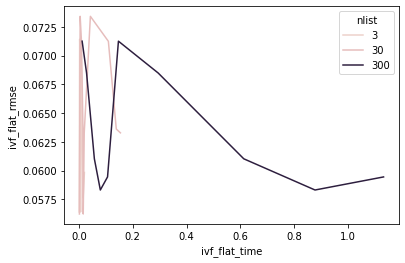

In [264]:
sns.lineplot(x='ivf_flat_time', y='ivf_flat_rmse', hue='nlist', data=df)
plt.show()

We will likely need multiple plots for different combinations of nbr embeddings, nlist and nprobe.  